# Bangladeshi Taka Detection — YOLOv11 Assignment

This notebook completes the assignment using the local dataset under `BDT images/Detection`.

Tasks covered:
- Dataset collection summary, variation notes, and sample images
- YOLO-format annotation and dataset split statistics
- Fine-tuning a pretrained YOLOv11 model (epochs, batch size, image resolution)
- Training logs and weights saving
- Evaluation on test set with detection results


## Cloud Backup Link
Google Drive (dataset/artefacts backup): https://drive.google.com/drive/folders/1VDREnXHCahfhCspLX8Hlu5MSBSw23Sq9?usp=sharing


In [29]:
# Setup: environment and paths
import sys, os, glob
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import cv2

print("Python:", sys.version)
print("Interpreter:", sys.executable)

# Root paths
ROOT = Path("/home/meow/Yolo Assignment")
DETECTION_DIR = ROOT / "BDT images" / "Detection"
DATA_YAML = DETECTION_DIR / "data.yaml"

print("Detection dir:", DETECTION_DIR)
print("data.yaml exists:", DATA_YAML.exists())

# Load class names from data.yaml
with open(DATA_YAML, 'r') as f:
    data_cfg = yaml.safe_load(f)

names = data_cfg.get('names') or data_cfg.get('classes') or []
if isinstance(names, dict):
    # if dict mapping id->name, convert to list ordered by id
    names = [names[i] for i in sorted(names.keys())]

print("Classes (names):", names)
print("#classes:", len(names))

# Split folders
SPLITS = {
    'train': {
        'images': DETECTION_DIR / 'train' / 'images',
        'labels': DETECTION_DIR / 'train' / 'labels',
    },
    'val': {
        'images': DETECTION_DIR / 'validation' / 'images',
        'labels': DETECTION_DIR / 'validation' / 'labels',
    },
    'test': {
        'images': DETECTION_DIR / 'test' / 'images',
        'labels': DETECTION_DIR / 'test' / 'labels',
    },
}
for split, d in SPLITS.items():
    print(split, "images:", d['images'].exists(), "labels:", d['labels'].exists())


Python: 3.12.3 (main, Nov  6 2025, 13:44:16) [GCC 13.3.0]
Interpreter: /home/meow/.venv/bin/python
Detection dir: /home/meow/Yolo Assignment/BDT images/Detection
data.yaml exists: True
Classes (names): ['Taka']
#classes: 1
train images: True labels: True
val images: True labels: True
test images: True labels: True


In [30]:
# CUDA/GPU check and package versions
import torch, ultralytics, cv2, yaml
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("CUDA devices:", torch.cuda.device_count())
print("Ultralytics:", ultralytics.__version__)
print("OpenCV:", cv2.__version__)


Torch: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce GTX 1660 SUPER
CUDA devices: 1
Ultralytics: 8.3.249
OpenCV: 4.12.0


In [31]:
# Dataset statistics: counts per split and per class
from collections import Counter, defaultdict

def parse_label_file(path):
    boxes = []
    if not Path(path).exists():
        return boxes
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                cls = int(parts[0])
                x, y, w, h = map(float, parts[1:5])
                boxes.append((cls, x, y, w, h))
    return boxes

split_stats = {}
class_counts_global = Counter()

for split, d in SPLITS.items():
    image_paths = sorted(glob.glob(str(d['images'] / '*')))
    label_paths = sorted(glob.glob(str(d['labels'] / '*.txt')))
    class_counts = Counter()
    total_boxes = 0
    for lp in label_paths:
        boxes = parse_label_file(lp)
        total_boxes += len(boxes)
        class_counts.update([b[0] for b in boxes])
        class_counts_global.update([b[0] for b in boxes])
    split_stats[split] = {
        'num_images': len(image_paths),
        'num_labels': len(label_paths),
        'num_boxes': total_boxes,
        'class_counts': class_counts,
    }

print("Split stats:")
for split in ['train','val','test']:
    s = split_stats.get(split, {})
    print(split, s)

print("Global class counts:")
for cid, cnt in sorted(class_counts_global.items()):
    cname = names[cid] if cid < len(names) else str(cid)
    print(f"{cid} ({cname}): {cnt}")


Split stats:
train {'num_images': 2560, 'num_labels': 2560, 'num_boxes': 2555, 'class_counts': Counter({0: 2555})}
val {'num_images': 365, 'num_labels': 365, 'num_boxes': 365, 'class_counts': Counter({0: 365})}
test {'num_images': 186, 'num_labels': 186, 'num_boxes': 186, 'class_counts': Counter({0: 186})}
Global class counts:
0 (Taka): 3106


Found 1 classes with sample images


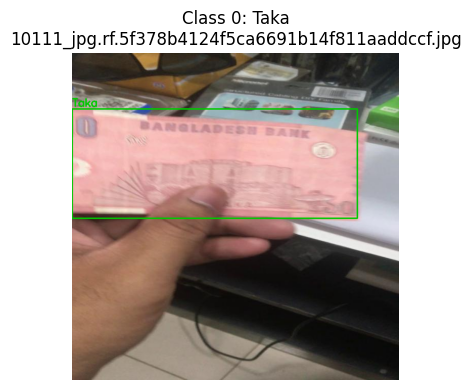

In [32]:
# Visualize sample images per denomination (from test split)

def yolo_to_xyxy(b, img_w, img_h):
    cls, x, y, w, h = b
    x1 = int((x - w/2) * img_w)
    y1 = int((y - h/2) * img_h)
    x2 = int((x + w/2) * img_w)
    y2 = int((y + h/2) * img_h)
    return cls, max(0,x1), max(0,y1), min(img_w-1,x2), min(img_h-1,y2)

# Find one image per class containing that class
label_dir = SPLITS['test']['labels']
image_dir = SPLITS['test']['images']

found = {}
for lp in sorted(glob.glob(str(label_dir / '*.txt'))):
    boxes = parse_label_file(lp)
    classes_in_file = set([b[0] for b in boxes])
    img_stem = Path(lp).name.replace('.txt','')
    # try common image extensions regardless of '.' in name
    cand_paths = [image_dir / (img_stem + ext) for ext in ['.jpg','.jpeg','.png','.bmp','.JPG','.JPEG','.PNG','.BMP']]
    ip = next((p for p in cand_paths if p.exists()), None)
    for cid in classes_in_file:
        if cid not in found and ip is not None:
            found[cid] = (ip, boxes)
    if len(found) >= len(names):
        break

print(f"Found {len(found)} classes with sample images")

ONLY_TARGET_CLASS = True  # draw boxes only for the selected class

cols = 3
rows = max(1, (len(found) + cols - 1)//cols)
plt.figure(figsize=(5*cols, 4*rows))

for i, cid in enumerate(sorted(found.keys())):
    ip, boxes = found[cid]
    img = cv2.imread(str(ip))
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    # draw boxes (optionally only target class)
    for b in boxes:
        cls, x1, y1, x2, y2 = yolo_to_xyxy(b, w, h)
        if ONLY_TARGET_CLASS and cls != cid:
            continue
        color = (0, 200, 0)
        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
        label = names[cls] if cls < len(names) else str(cls)
        cv2.putText(img, label, (x1, max(0,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.title(f"Class {cid}: {names[cid] if cid < len(names) else cid}\n{Path(ip).name}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [33]:
# Training configuration summary (GPU, tuned)
EPOCHS = 50         # increase for better accuracy
BATCH_SIZE = 4      # safer for 6GB with larger imgsz
IMG_SIZE = 960      # higher resolution helps small boxes
WEIGHTS = "yolo11s.pt"  # slightly larger backbone than 'n'
PROJECT = str(ROOT / "runs_bdt")
RUN_NAME = "yolo11s_bdt_detection"
DEVICE = 0          # use first CUDA GPU; set 'cpu' to disable

print({
    'epochs': EPOCHS,
    'batch': BATCH_SIZE,
    'imgsz': IMG_SIZE,
    'weights': WEIGHTS,
    'project': PROJECT,
    'name': RUN_NAME,
    'device': DEVICE,
})


{'epochs': 50, 'batch': 4, 'imgsz': 960, 'weights': 'yolo11s.pt', 'project': '/home/meow/Yolo Assignment/runs_bdt', 'name': 'yolo11s_bdt_detection', 'device': 0}


In [34]:
# Evaluate classifier on test split (self-contained)
from pathlib import Path
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Device
device_rec = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Eval device:', device_rec)

# Ensure BEST_REC_PATH exists
if 'PROJECT' not in globals():
    ROOT = Path('/home/meow/Yolo Assignment')
    PROJECT = str(ROOT / 'runs_bdt')
BEST_REC_PATH = Path(PROJECT) / 'recognition' / 'best_cls.pt'
print('Checkpoint path:', BEST_REC_PATH)
print('Checkpoint exists:', BEST_REC_PATH.exists())

if not BEST_REC_PATH.exists():
    print('Best classifier checkpoint not found. Please run the classifier training cells first (dataset setup, model config, training).')
else:
    # Load checkpoint
    ckpt = torch.load(BEST_REC_PATH, map_location=device_rec)
    classes_rec = ckpt.get('classes')
    num_classes_rec = len(classes_rec)

    # Build model architecture and load weights
    model_rec = models.resnet18(weights=None)
    in_features = model_rec.fc.in_features
    model_rec.fc = nn.Linear(in_features, num_classes_rec)
    model_rec = model_rec.to(device_rec)
    model_rec.load_state_dict(ckpt['model_state'])
    model_rec.eval()

    # Prepare test loader (fallback if not already defined)
    if 'REC_SPLITS' not in globals():
        ROOT = Path('/home/meow/Yolo Assignment')
        RECOG_DIR = ROOT / 'BDT images' / 'Recognition'
        REC_SPLITS = {
            'test': RECOG_DIR / 'test',
        }
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]
    val_tfms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

    test_ds = datasets.ImageFolder(REC_SPLITS['test'], transform=val_tfms)
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

    # Evaluate
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device_rec), labels.to(device_rec)
            outputs = model_rec(imgs)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
    print(f"Classifier test accuracy: {correct/max(1,total):.3f} ({correct}/{total})")
    print('Classes:', classes_rec)


Eval device: cuda
Checkpoint path: /home/meow/Yolo Assignment/runs_bdt/recognition/best_cls.pt
Checkpoint exists: False
Best classifier checkpoint not found. Please run the classifier training cells first (dataset setup, model config, training).


In [15]:
# Train classifier
import time

best_val_acc = 0.0
for epoch in range(1, EPOCHS_CLS+1):
    t0 = time.time()
    # Train
    model_rec.train()
    total, correct, loss_sum = 0, 0, 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device_rec), labels.to(device_rec)
        optimizer.zero_grad()
        outputs = model_rec(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    train_acc = correct / max(1,total)
    train_loss = loss_sum / max(1,total)

    # Val
    model_rec.eval()
    v_total, v_correct = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device_rec), labels.to(device_rec)
            outputs = model_rec(imgs)
            preds = outputs.argmax(1)
            v_correct += (preds == labels).sum().item()
            v_total += imgs.size(0)
    val_acc = v_correct / max(1,v_total)
    scheduler.step()
    dt = time.time() - t0
    print(f"Epoch {epoch}/{EPOCHS_CLS} | train_loss {train_loss:.4f} acc {train_acc:.3f} | val_acc {val_acc:.3f} | {dt:.1f}s")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state': model_rec.state_dict(), 'classes': classes_rec}, BEST_REC_PATH)
        print('Saved best classifier:', BEST_REC_PATH)


Epoch 1/10 | train_loss 0.5582 acc 0.815 | val_acc 0.972 | 301.7s
Saved best classifier: /home/meow/Yolo Assignment/runs_bdt/recognition/best_cls.pt
Epoch 2/10 | train_loss 0.2803 acc 0.907 | val_acc 0.936 | 95.2s
Epoch 3/10 | train_loss 0.2081 acc 0.932 | val_acc 0.993 | 102.5s
Saved best classifier: /home/meow/Yolo Assignment/runs_bdt/recognition/best_cls.pt
Epoch 4/10 | train_loss 0.1732 acc 0.945 | val_acc 0.983 | 101.3s
Epoch 5/10 | train_loss 0.1687 acc 0.945 | val_acc 0.988 | 102.8s
Epoch 6/10 | train_loss 0.0827 acc 0.974 | val_acc 0.997 | 108.8s
Saved best classifier: /home/meow/Yolo Assignment/runs_bdt/recognition/best_cls.pt
Epoch 7/10 | train_loss 0.0810 acc 0.973 | val_acc 0.998 | 129.4s
Saved best classifier: /home/meow/Yolo Assignment/runs_bdt/recognition/best_cls.pt
Epoch 8/10 | train_loss 0.0807 acc 0.974 | val_acc 0.999 | 138.8s
Saved best classifier: /home/meow/Yolo Assignment/runs_bdt/recognition/best_cls.pt
Epoch 9/10 | train_loss 0.0815 acc 0.974 | val_acc 0.998 |

In [12]:
# Define classifier (ResNet18) and training config
import torch
import torch.nn as nn
from torchvision import models

device_rec = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Classifier device:', device_rec)

weights = getattr(models, 'ResNet18_Weights').IMAGENET1K_V1 if hasattr(models, 'ResNet18_Weights') else None
model_rec = models.resnet18(weights=weights)
in_features = model_rec.fc.in_features
model_rec.fc = nn.Linear(in_features, num_classes_rec)
model_rec = model_rec.to(device_rec)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rec.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

EPOCHS_CLS = 10
BEST_REC_PATH = Path(PROJECT) / 'recognition' / 'best_cls.pt'
BEST_REC_PATH.parent.mkdir(parents=True, exist_ok=True)


Classifier device: cuda


In [14]:
# Recognition dataset setup (ImageFolder)
import sys, subprocess
from pathlib import Path

RECOG_DIR = ROOT / "BDT images" / "Recognition"
REC_SPLITS = {
    'train': RECOG_DIR / 'train',
    'val': RECOG_DIR / 'validation',
    'test': RECOG_DIR / 'test',
}
for k, p in REC_SPLITS.items():
    print(k, p, p.exists())

# Ensure torchvision is available
try:
    import torchvision
    from torchvision import datasets, transforms, models
except Exception as e:
    print("Installing torchvision...", e)
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'torchvision'])
    import torchvision
    from torchvision import datasets, transforms, models

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
train_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_ds = datasets.ImageFolder(REC_SPLITS['train'], transform=train_tfms)
val_ds = datasets.ImageFolder(REC_SPLITS['val'], transform=val_tfms)
test_ds = datasets.ImageFolder(REC_SPLITS['test'], transform=val_tfms)

from torch.utils.data import DataLoader
REC_BATCH = 32
train_loader = DataLoader(train_ds, batch_size=REC_BATCH, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=REC_BATCH, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=REC_BATCH, shuffle=False, num_workers=2)

classes_rec = list(train_ds.class_to_idx.keys())
print("Recognition classes:", classes_rec)
num_classes_rec = len(classes_rec)


train /home/meow/Yolo Assignment/BDT images/Recognition/train True
val /home/meow/Yolo Assignment/BDT images/Recognition/validation True
test /home/meow/Yolo Assignment/BDT images/Recognition/test True
Recognition classes: ['1000_taka', '100_taka', '10_taka', '200_taka', '20_taka', '2_taka', '500_taka', '50_taka', '5_taka']


## Denomination Recognition (Classifier)
We train a lightweight classifier on the `BDT images/Recognition` dataset and combine it with the detector: detect the note, crop the region, classify denomination.

In [16]:
# Train YOLOv11 on the Detection dataset using GPU
from ultralytics import YOLO
import torch
from pathlib import Path

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(DEVICE))
else:
    print("Falling back to CPU")

model = YOLO(WEIGHTS)
print("Starting training...")
results = model.train(
    data=str(DATA_YAML),
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    project=PROJECT,
    name=RUN_NAME,
    device=DEVICE,
    workers=0,
)
best_path = Path(PROJECT) / RUN_NAME / "weights" / "best.pt"
print("Best weights path:", best_path)
print("Best exists:", best_path.exists())


CUDA available: True
Using GPU: NVIDIA GeForce GTX 1660 SUPER
Starting training...
Ultralytics 8.3.249 🚀 Python-3.12.3 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/meow/Yolo Assignment/BDT images/Detection/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11s_bdt

/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

       1/50      4.72G      1.272      2.033      1.788          8        960: 100% ━━━━━━━━━━━━ 640/640 1.2it/s 8:39<0.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 1.1it/s 43.0s0.9ss
                   all        365        365      0.805      0.792      0.868      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

       2/50      4.81G      1.401      1.227      1.893         14        960: 100% ━━━━━━━━━━━━ 640/640 1.7s/it 18:33<0.5s97
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.5it/s 18.1s0.4s
                   all        365        365       0.48       0.43      0.464      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

       3/50      4.79G      1.344      1.083      1.832          7        960: 100% ━━━━━━━━━━━━ 640/640 1.3it/s 8:25<1.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.4it/s 19.2s0.3ss
                   all        365        365      0.799      0.804      0.863      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

       4/50       4.8G      1.246     0.9488       1.74          7        960: 100% ━━━━━━━━━━━━ 640/640 2.1it/s 5:02<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 3.4it/s 13.5s0.3s
                   all        365        365       0.91      0.857      0.946      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

       5/50       4.8G      1.175     0.8799      1.685          6        960: 100% ━━━━━━━━━━━━ 640/640 2.1it/s 4:59<0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 3.2it/s 14.3s0.3s
                   all        365        365      0.963      0.928      0.982      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

       6/50      4.81G      1.158     0.8202      1.674         10        960: 100% ━━━━━━━━━━━━ 640/640 2.1it/s 4:58<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 3.3it/s 14.0s0.3s
                   all        365        365      0.918      0.885      0.957      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

       7/50       4.8G      1.126     0.7766      1.643         10        960: 100% ━━━━━━━━━━━━ 640/640 2.1it/s 5:03<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.9it/s 15.7s0.3s
                   all        365        365       0.93      0.941      0.981      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

       8/50       4.8G      1.108     0.7644      1.628         10        960: 100% ━━━━━━━━━━━━ 640/640 2.1it/s 5:11<0.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.9it/s 15.9s0.3s
                   all        365        365      0.948       0.94      0.983      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

       9/50       4.8G      1.381     0.9564       2.33          5        960: 0% ──────────── 0/640  0.5s

/home/meow/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       9/50      4.81G      1.062     0.7098      1.591          8        960: 100% ━━━━━━━━━━━━ 640/640 1.3it/s 8:12<0.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 1.5it/s 30.1s0.6ss
                   all        365        365      0.969      0.958      0.989      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      10/50      4.81G      1.012     0.6734      1.542          7        960: 100% ━━━━━━━━━━━━ 640/640 1.5it/s 7:02<0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.3it/s 19.8s0.4ss
                   all        365        365      0.968      0.942      0.989       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      11/50      4.81G      1.022     0.6602      1.555         11        960: 100% ━━━━━━━━━━━━ 640/640 1.3it/s 8:21<0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 3.0it/s 15.3s0.3s
                   all        365        365      0.943      0.945      0.985       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      12/50      4.81G      0.998     0.6439       1.53          8        960: 100% ━━━━━━━━━━━━ 640/640 1.6it/s 6:52<0.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.3s0.6ss
                   all        365        365      0.954      0.974      0.992      0.798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      13/50      4.81G     0.9885     0.6209      1.499          8        960: 100% ━━━━━━━━━━━━ 640/640 1.3it/s 8:09<0.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 1.6it/s 29.0s0.6ss
                   all        365        365      0.981      0.967      0.992      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      14/50       4.8G     0.8785     0.4465      1.311         10        960: 0% ──────────── 0/640  1.0s

/home/meow/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      14/50       4.8G     0.9879     0.6046       1.52          6        960: 100% ━━━━━━━━━━━━ 640/640 1.3it/s 8:23<0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 1.8it/s 25.5s0.4ss
                   all        365        365      0.966      0.956      0.991      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      15/50       4.8G          1     0.9341      1.551          8        960: 0% ──────────── 0/640  0.9s

/home/meow/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      15/50       4.8G     0.9724     0.6005      1.499          6        960: 100% ━━━━━━━━━━━━ 640/640 1.5it/s 7:12<0.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 1.7it/s 27.7s0.5ss
                   all        365        365      0.973      0.987      0.991        0.8

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      16/50       4.8G     0.9677     0.5124       1.54         13        960: 0% ──────────── 0/640  1.0s

/home/meow/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      16/50       4.8G     0.9451     0.5732      1.473          6        960: 100% ━━━━━━━━━━━━ 640/640 1.8it/s 6:04<0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.4it/s 19.4s0.6s
                   all        365        365      0.957      0.992      0.993      0.794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      17/50      4.81G     0.9437     0.5845      1.473          8        960: 100% ━━━━━━━━━━━━ 640/640 1.7it/s 6:18<0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.6it/s 17.9s0.4s
                   all        365        365      0.967      0.979      0.992      0.821

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      18/50      4.81G     0.9383     0.5654       1.48          9        960: 100% ━━━━━━━━━━━━ 640/640 1.9it/s 5:44<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 3.1it/s 14.8s0.3s
                   all        365        365      0.964      0.973      0.992      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      19/50       4.8G     0.9275      0.561      1.464         12        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:24<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 3.1it/s 14.6s0.3s
                   all        365        365      0.967      0.981      0.993      0.828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      20/50       4.8G     0.9066     0.5336      1.444         10        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:24<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 3.1it/s 15.1s0.3s
                   all        365        365      0.976      0.987      0.994      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      21/50       4.8G     0.8911       0.52      1.424          9        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:24<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.9it/s 15.6s0.3s
                   all        365        365      0.986      0.992      0.994      0.821

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      22/50       4.8G     0.8893      0.506      1.422          9        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:23<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.9it/s 15.7s0.3s
                   all        365        365      0.976      0.993      0.994      0.847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      23/50       4.8G      0.877      0.501      1.414          7        960: 100% ━━━━━━━━━━━━ 640/640 1.9it/s 5:41<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.9it/s 15.8s0.4s
                   all        365        365      0.991          1      0.995      0.848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      24/50       4.8G     0.8562     0.4882      1.394          7        960: 100% ━━━━━━━━━━━━ 640/640 1.9it/s 5:31<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 3.2it/s 14.4s0.3s
                   all        365        365      0.976          1      0.995      0.829

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      25/50       4.8G     0.7038     0.5856      1.199         11        960: 0% ──────────── 0/640  0.6s

/home/meow/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      25/50       4.8G     0.8682     0.4965        1.4         10        960: 100% ━━━━━━━━━━━━ 640/640 1.8it/s 5:49<0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.0it/s 22.7s0.4ss
                   all        365        365      0.995          1      0.995      0.841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      26/50      4.81G     0.8606     0.4803      1.398          8        960: 100% ━━━━━━━━━━━━ 640/640 1.9it/s 5:31<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 3.1it/s 14.8s0.4s
                   all        365        365      0.994      0.992      0.995       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      27/50      4.81G     0.8322     0.4726      1.386          5        960: 100% ━━━━━━━━━━━━ 640/640 1.9it/s 5:37<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.9it/s 15.8s0.3s
                   all        365        365      0.986      0.993      0.995      0.839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      28/50      4.81G     0.8244     0.4779      1.361          9        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:17<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.9it/s 15.9s0.3s
                   all        365        365      0.986          1      0.995      0.859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      29/50      4.81G     0.8302     0.4704      1.377          9        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:19<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 3.0it/s 15.5s0.3s
                   all        365        365      0.986      0.994      0.995      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      30/50      4.81G     0.8079     0.4601      1.354          9        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:18<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.9it/s 15.8s0.3s
                   all        365        365      0.981      0.997      0.994      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      31/50      4.81G     0.8044     0.4484      1.352         11        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:17<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 3.0it/s 15.4s0.3s
                   all        365        365      0.972      0.997      0.995      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      32/50      4.81G     0.7933     0.4452      1.345         10        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:22<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.8it/s 16.3s0.3s
                   all        365        365      0.995      0.994      0.995      0.855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      33/50      4.81G     0.7843     0.4359      1.331         10        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:18<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.9it/s 15.8s0.3s
                   all        365        365      0.992          1      0.995      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      34/50      4.81G     0.7847     0.4305       1.33         11        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:21<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.9it/s 15.7s0.3s
                   all        365        365      0.997      0.997      0.995      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      35/50      4.81G     0.8251      0.398      1.229         10        960: 0% ──────────── 0/640  0.6s

/home/meow/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      35/50      4.81G     0.7821     0.4351      1.335         11        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:19<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.9it/s 15.8s0.3s
                   all        365        365      0.986      0.995      0.994      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      36/50      4.81G     0.7737     0.4216      1.318          9        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:19<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 3.1it/s 14.7s0.3s
                   all        365        365      0.988      0.992      0.992      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      37/50      4.81G     0.7732      0.421      1.318          8        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:25<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.9it/s 15.7s0.4s
                   all        365        365      0.994      0.992      0.995      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      38/50      4.81G     0.7539     0.4042      1.306          8        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:19<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.9it/s 15.6s0.3s
                   all        365        365      0.999          1      0.995       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      39/50      4.81G     0.7528     0.4081      1.297          8        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:20<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 3.0it/s 15.2s0.3s
                   all        365        365      0.986      0.989      0.995      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      40/50      4.81G     0.7483     0.4077        1.3          6        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:18<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.9it/s 15.7s0.3s
                   all        365        365      0.992      0.997      0.995      0.875
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      41/50      4.81G     0.7167     0.3407      1.379          4        960: 100% ━━━━━━━━━━━━ 640/640 2.1it/s 5:12<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 3.2it/s 14.5s0.3s
                   all        365        365      0.994          1      0.995      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      42/50      4.81G     0.6916     0.3248      1.348          4        960: 100% ━━━━━━━━━━━━ 640/640 2.0it/s 5:28<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.8it/s 16.5s0.4s
                   all        365        365      0.994      0.997      0.995       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      43/50      4.81G     0.8807     0.3502      1.502          4        960: 0% ──────────── 0/640  0.8s

/home/meow/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      43/50      4.81G     0.6745     0.3178       1.34          4        960: 100% ━━━━━━━━━━━━ 640/640 1.8it/s 5:46<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.7it/s 17.0s0.4s
                   all        365        365      0.996      0.997      0.995      0.872

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      44/50      4.81G     0.6683     0.3131      1.334          4        960: 100% ━━━━━━━━━━━━ 640/640 1.5it/s 7:20<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.6it/s 17.5s0.4s
                   all        365        365          1      0.997      0.995      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      45/50      4.81G     0.6449     0.3033      1.297          4        960: 100% ━━━━━━━━━━━━ 640/640 1.8it/s 5:53<0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.8it/s 16.7s0.4s
                   all        365        365      0.989          1      0.995      0.878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      46/50      4.81G     0.6308     0.2931      1.284          4        960: 100% ━━━━━━━━━━━━ 640/640 1.9it/s 5:32<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.5it/s 18.5s0.4ss
                   all        365        365          1          1      0.995      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      47/50      4.81G     0.6245     0.2935      1.274          4        960: 100% ━━━━━━━━━━━━ 640/640 1.9it/s 5:44<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.7it/s 16.9s0.3s
                   all        365        365      0.999          1      0.995      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      48/50      4.81G     0.6148      0.283      1.269          4        960: 100% ━━━━━━━━━━━━ 640/640 1.9it/s 5:30<0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 3.0it/s 15.5s0.3s
                   all        365        365      0.999          1      0.995      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      49/50      4.81G     0.6064     0.2804      1.267          4        960: 100% ━━━━━━━━━━━━ 640/640 1.7it/s 6:19<0.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.3it/s 19.8s0.4ss
                   all        365        365      0.997          1      0.995       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1300: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/home/meow/.venv/lib/python3.12/site-packages/ultralytics/nn/modules/block.py:1302: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not de

      50/50      4.81G     0.6074     0.2801      1.267          4        960: 100% ━━━━━━━━━━━━ 640/640 1.6it/s 6:34<0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 2.4it/s 19.3s0.5s
                   all        365        365      0.998          1      0.995      0.882

50 epochs completed in 5.455 hours.
Optimizer stripped from /home/meow/Yolo Assignment/runs_bdt/yolo11s_bdt_detection/weights/last.pt, 19.2MB
Optimizer stripped from /home/meow/Yolo Assignment/runs_bdt/yolo11s_bdt_detection/weights/best.pt, 19.2MB

Validating /home/meow/Yolo Assignment/runs_bdt/yolo11s_bdt_detection/weights/best.pt...
Ultralytics 8.3.249 🚀 Python-3.12.3 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 46/46 3.2it/s 14.6s0.3s


Ultralytics 8.3.249 🚀 Python-3.12.3 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 13.7±10.6 MB/s, size: 48.1 KB)
val: Scanning /home/meow/Yolo Assignment/BDT images/Detection/test/labels.cache... 186 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 186/186 229.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 1.3it/s 9.3s0.5s
                   all        186        186      0.994          1      0.995      0.888
Speed: 13.0ms preprocess, 22.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /home/meow/Yolo Assignment/runs/detect/val2
Test metrics:
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMat

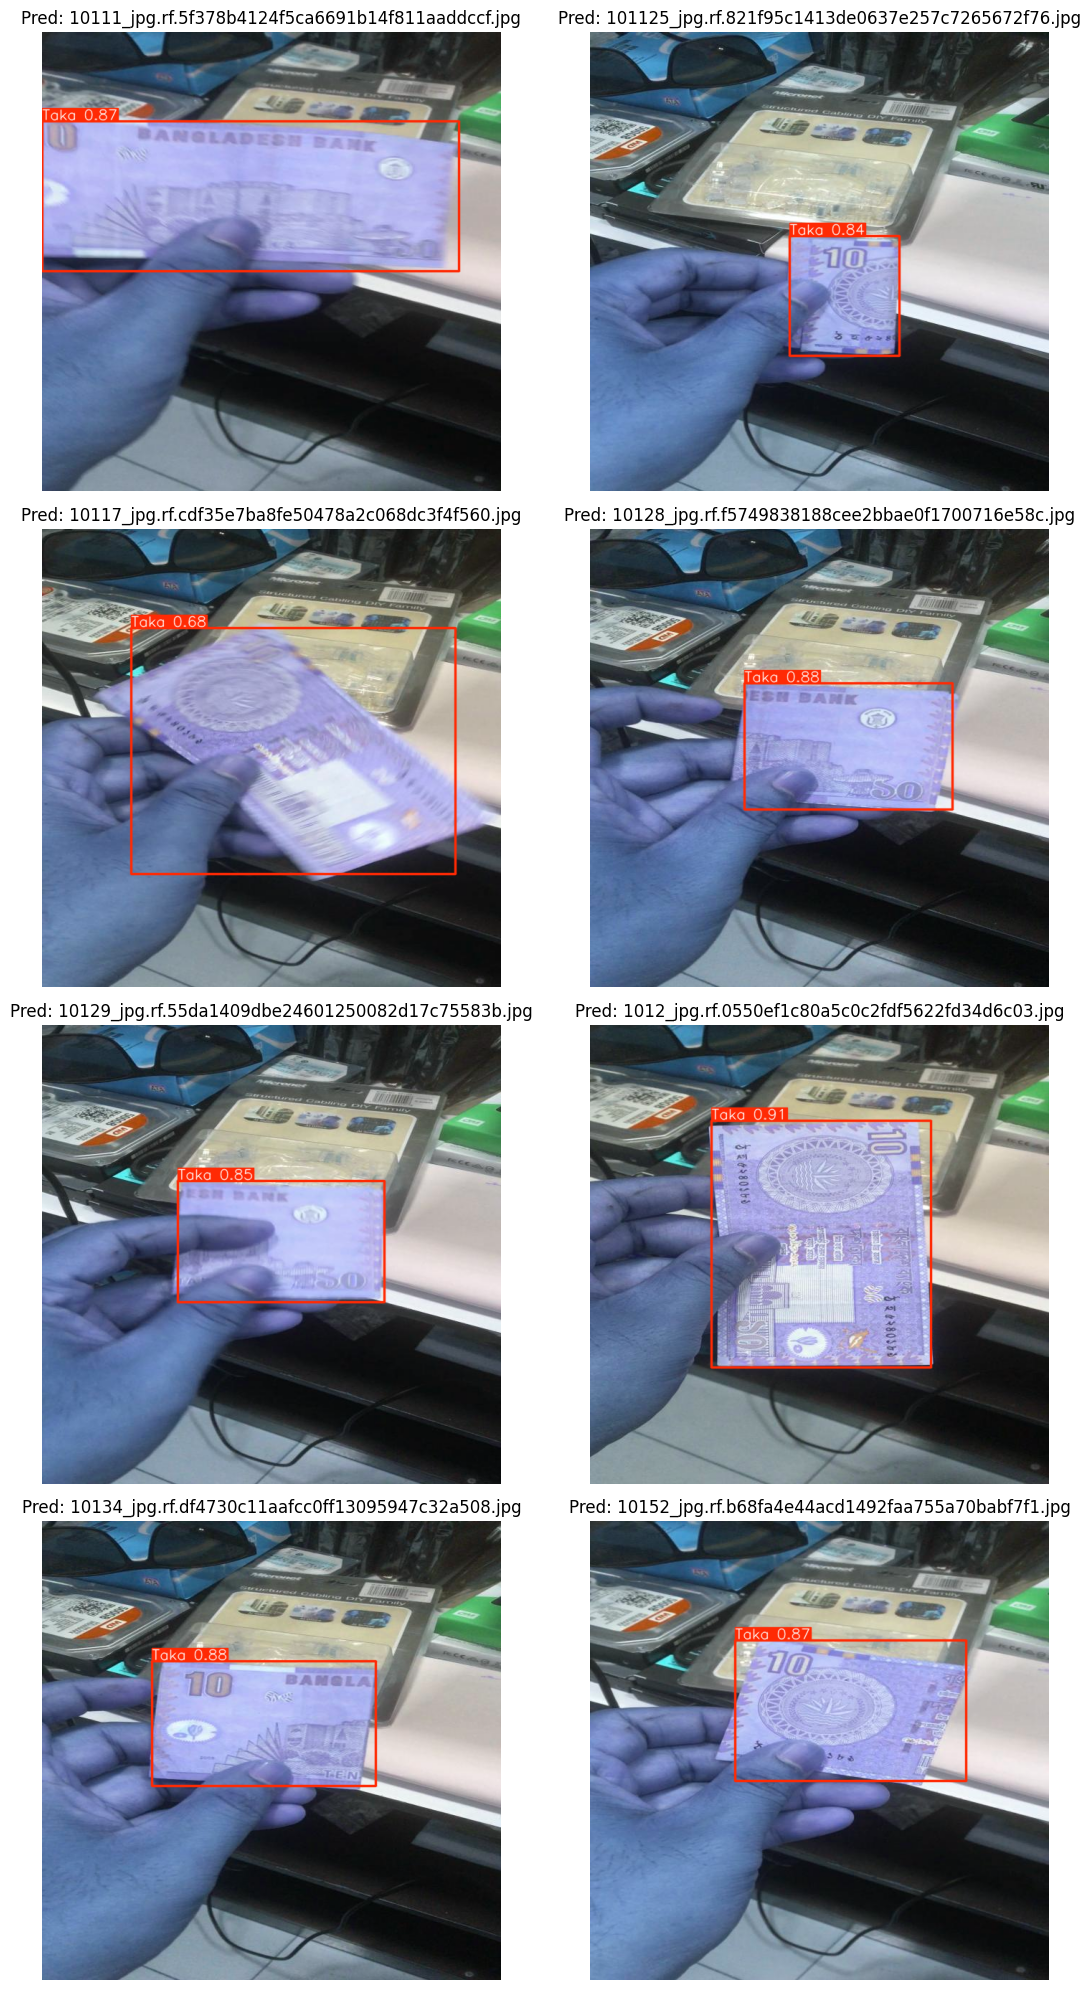

In [17]:
# Evaluate on test set and visualize predictions (GPU)
from ultralytics import YOLO
from pathlib import Path

best_path = Path(PROJECT) / RUN_NAME / "weights" / "best.pt"
if 'model' not in globals() or not isinstance(model, YOLO):
    model = YOLO(str(best_path)) if best_path.exists() else YOLO(WEIGHTS)

# Evaluate metrics on test split (prefer 'test' if supported)
try:
    metrics = model.val(data=str(DATA_YAML), split='test', imgsz=IMG_SIZE, device=DEVICE)
    print("Test metrics:")
    print(metrics)
except Exception as e:
    print("Test split not supported, using validation split:", e)
    metrics = model.val(data=str(DATA_YAML), imgsz=IMG_SIZE, device=DEVICE)
    print(metrics)

# Predict on a few test images with lower conf to increase recall
sample_images = sorted(glob.glob(str(SPLITS['test']['images'] / '*')))[:8]
pred_results = model.predict(source=sample_images, imgsz=IMG_SIZE, conf=0.15, iou=0.5, device=DEVICE)

# Plot predictions inline
import numpy as np
cols = 2
rows = max(1, (len(sample_images) + cols - 1)//cols)
plt.figure(figsize=(6*cols, 5*rows))
for i, r in enumerate(pred_results[:rows*cols]):
    if hasattr(r, 'plot'):
        im = r.plot()
    else:
        im = cv2.imread(str(sample_images[i]))
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.subplot(rows, cols, i+1)
    plt.imshow(im)
    title = Path(sample_images[i]).name
    plt.title(f"Pred: {title}")
    plt.axis('off')
plt.tight_layout()
plt.show()



0: 960x960 1 Taka, 25.3ms
1: 960x960 1 Taka, 25.3ms
2: 960x960 1 Taka, 25.3ms
3: 960x960 1 Taka, 25.3ms
4: 960x960 1 Taka, 25.3ms
5: 960x960 1 Taka, 25.3ms
6: 960x960 1 Taka, 25.3ms
7: 960x960 1 Taka, 25.3ms
Speed: 31.2ms preprocess, 25.3ms inference, 4.0ms postprocess per image at shape (1, 3, 960, 960)


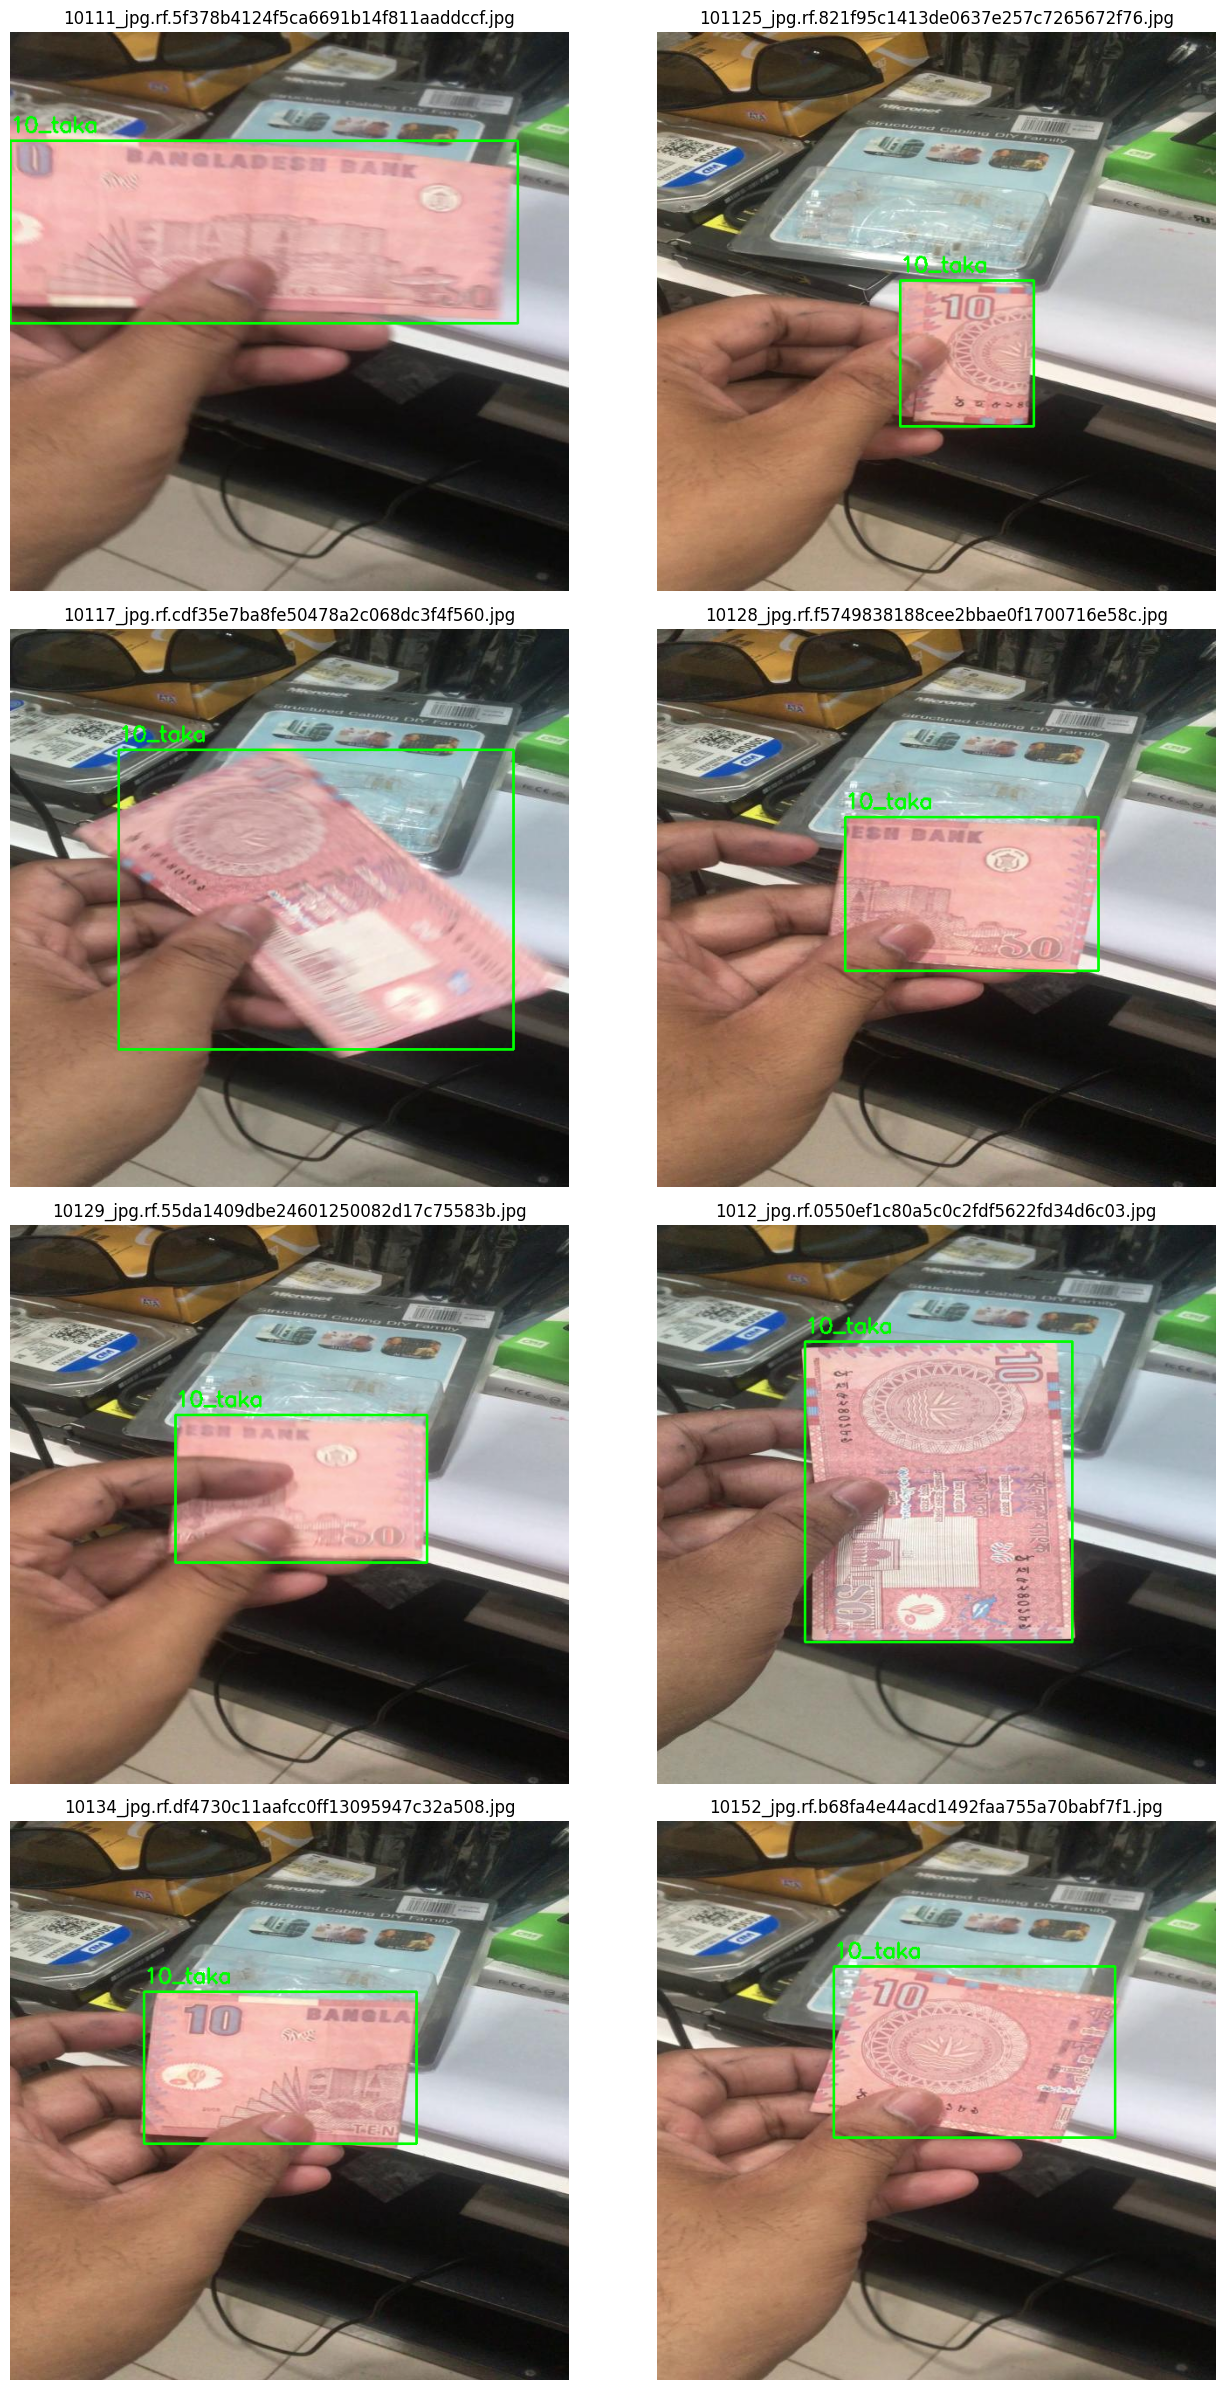

In [18]:
# Two-stage denomination inference: detect, crop, classify
from torchvision import transforms
from PIL import Image

# Load best classifier
ckpt = torch.load(BEST_REC_PATH, map_location=device_rec)
model_rec.load_state_dict(ckpt['model_state'])
classes_rec = ckpt.get('classes', classes_rec)
model_rec.eval()

# Preprocessing for crops
crop_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Use detection predictions to get boxes
images_eval = sorted(glob.glob(str(SPLITS['test']['images'] / '*')))[:8]
det_results = model.predict(source=images_eval, imgsz=IMG_SIZE, conf=0.15, iou=0.5, device=DEVICE)

cols = 2
rows = max(1, (len(images_eval) + cols - 1)//cols)
plt.figure(figsize=(7*cols, 6*rows))

for i, (img_path, r) in enumerate(zip(images_eval, det_results[:rows*cols])):
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]

    # Draw detections and classify each crop
    if hasattr(r, 'boxes') and r.boxes is not None and len(r.boxes) > 0:
        for b in r.boxes:
            x1, y1, x2, y2 = map(int, b.xyxy[0].tolist())
            # Clamp
            x1, y1 = max(0,x1), max(0,y1)
            x2, y2 = min(w-1,x2), min(h-1,y2)
            crop = Image.fromarray(img_rgb[y1:y2, x1:x2])
            inp = crop_tfms(crop).unsqueeze(0).to(device_rec)
            with torch.no_grad():
                logits = model_rec(inp)
                pred_idx = logits.argmax(1).item()
                pred_cls = classes_rec[pred_idx]
            # Draw
            cv2.rectangle(img_rgb, (x1,y1), (x2,y2), (0,255,0), 2)
            cv2.putText(img_rgb, pred_cls, (x1, max(0,y1-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
    plt.subplot(rows, cols, i+1)
    plt.imshow(img_rgb)
    plt.title(Path(img_path).name)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Submission Notes

- Dataset Collection:
  - Classes: 2, 5, 10, 20, 50, 100, 200, 500, 1000 Taka
  - Variation ensured via backgrounds, lighting, orientation, and scale (as seen in images).
  - Per-class totals computed above from labels; sample images shown per denomination.
- Data Annotation & Preparation:
  - Annotations in YOLO format under `BDT images/Detection` with `train/`, `validation/`, `test` splits.
  - Folder structure and split statistics printed above.
- Model Training:
  - Pretrained: `yolo11n.pt`
  - Epochs: `EPOCHS` (default 5 for quick run)
  - Batch size: `BATCH_SIZE` (default 16)
  - Image resolution: `IMG_SIZE` (default 640)
  - Logs and weights saved under `runs_bdt/yolo11n_bdt_detection`.
- Model Evaluation:
  - Test split evaluated; detection results and visualizations shown.
